# Data Wrangling

This is part of the analysis of Opioid Prescription project. In this notebook the data is prepared for analysis.

# import packages and important functions

In [1]:
#used to stop program under certain conditions
from sys import exit

#dataframes and numerical processes
import pandas as pd
import numpy as np

#importing database from file or online
import csv
from urllib import request
from sodapy import Socrata

# visualization
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import seaborn as sns
import plotly.plotly as py

#for static map
from matplotlib.cm import get_cmap
import cartopy.crs as ccrs
from cartopy.feature import NaturalEarthFeature
import cartopy.feature as cfeature

#for converting latitude and longitude into distance
from math import sin, cos, sqrt, atan2, radians

#Do not display warnings
import warnings
warnings.simplefilter(action='ignore', category=UserWarning)

#if value is NaN, return ifnan_value, otherwise return value
def if_null_value(value,if_nan_value):
    return (if_nan_value if pd.isnull(value) else value)

# If state is listed as "ZZ" or "XX", than zip codeis null.
# Fill with 1 if 'ZZ' (unknown location)
# or 2 if 'XX'. Not in the US 
# or 3 if 'AP' for Pacific armed forces
def fill_zip_code(state,zipcode):
    final_code = ''
    if not pd.isnull(zipcode):
        final_code = zipcode
    elif state == 'ZZ':
        final_code = 1
    elif state == 'XX':
        final_code = 2
    elif state == 'AP':
        final_code = 3
    else:
        print('ERROR: state: \'{}\' not recognized'.format(state))
        exit()
    return final_code


#combines strings, used to combine first and last names with spaces between.
def combine_strings(*strings):
    combine = ''
    for x in strings:
        if isinstance(x,str):
          combine += x + ' '
    if(combine == ''):
        return combine
    else:
        return combine[0:-1] 

#if latitude and longitude of zip code don't match the others of the city, replace them with
#mode. This is done in cases there mistake in the database
def replace_lat_and_lat(lat_long,median_lat_long,lat_wrong,long_wrong):
    if(lat_wrong or long_wrong):
        return lat_long
    else:
        return median_lat_long

#This function returns the city with the lowest distance based on longitude and latitude  
def smallest_distance_city(long,lat,long_lat_df):
    return long_lat_df[['Longitude','Latitude']].apply(lambda x:
                                                             (get_distance(x[0],x[1],long,lat)),
                                                             axis=1).idxmin()
    
#get distance of two longitude and latitude     
def get_distance(long1,lat1,long2,lat2):
    # approximate radius of earth in km
    R = 6373.0
    long1,lat1,long2,lat2  = radians(long1),radians(lat1),radians(long2),radians(lat2)
    dlong,dlat = long1 - long2,lat2 - lat1
    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlong / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))
    distance = R * c
    return distance

# Create dataframe of population by zipcode
The population of a zip code is replaced with the sum of populations of zip codes in the same city. 
Considering that these zip codes will be geographically close, the city population is a better estimate of the population
of a health provider's cliental. The zip code is linked to a city and state using a second database (See below). This will also also fill many of empty populations zip codes with empty entries.

Source: https://simplemaps.com/data/us-zips 
accessed: November 7, 2018

In [2]:
def create_pop_dataframe():
    #population from the 2010 census
    filename = 'Zip_code_to_address/uszipsv1.4.csv'
    population_df = pd.read_csv(filename)[['zip','city','state_id','lat','lng','population']]
    population_df.rename(columns={'zip':'zipcode'},inplace=True)
      
    #summing over the population of zip codes in the same city
    #and replacing the population with it.This will also fill null values
    location_pop=population_df.groupby(['state_id','city'])['city','state_id','population'].sum().reset_index()

    #round the longitude and latitude to 1 digits then take the mode of a city. 
    #This is used to determine if there are any cities that the longitude and latitude 
    # are incorrect.
    population_df['lat'] = population_df['lat'].fillna(0)
    population_df['lng'] = population_df['lng'].fillna(0)
    location_pop['lat median'] = population_df.groupby(['state_id','city']).median().reset_index()['lat']    
    location_pop['lng median'] = population_df.groupby(['state_id','city']).median().reset_index()['lng']
    
    population_df=population_df.merge(location_pop,how='left',on=['state_id','city'])
    population_df.rename(columns={'population_x':'population','population_y':'population sum'},inplace=True)

    #if longitude and latitude are too far from median for the city, it is most likely wrong.
    #Replace with median.
    population_df['lat match']=population_df[['lat','lat median']].apply(lambda x:(abs(x[0]-x[1])<2) ,axis=1)
    population_df['lng match']=population_df[['lng','lng median']].apply(lambda x:(abs(x[0]-x[1])<2) ,axis=1)
    population_df['lat'] = population_df[['lat','lat median','lat match','lng match']].apply(lambda x:replace_lat_and_lat(x[0],x[1],x[2],x[3]),axis=1)    
    population_df['lng'] = population_df[['lng','lng median','lat match','lng match']].apply(lambda x:replace_lat_and_lat(x[0],x[1],x[2],x[3]),axis=1)  
    population_df.drop(columns=['lat match','lng match','lat median','lng median'],axis=1,inplace=True)  
    
    
    #if the population sum is zero. Do not use it because the population of all the zip code in that city are null
    population_df['population'] =  population_df[['population','population sum']].apply(lambda x:
                                                                                          x[1] if x[1] != 0 
                                                                                          else x[0],
                                                                                         axis=1)
    population_df.drop(columns='population sum',axis=1,inplace=True)
    
    
    return population_df,location_pop
    
if __name__ == '__main__':
    population_df,location_pop=create_pop_dataframe()

# Population Map

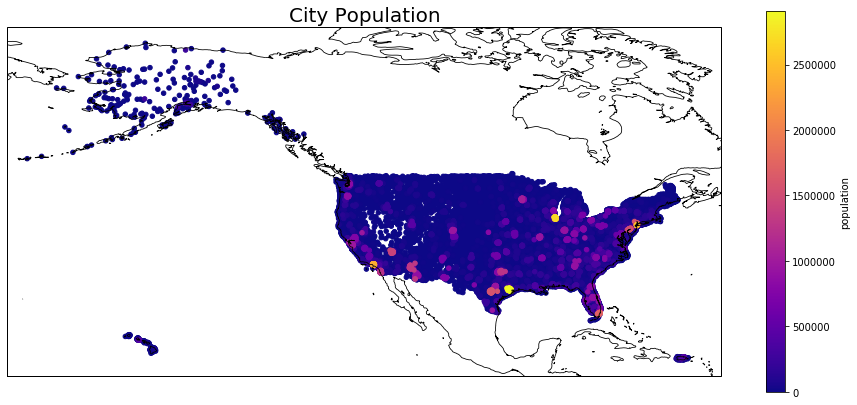

In [4]:

population_df.sort_values(by='population',ascending=True,inplace=True)
lat = population_df['lat']
lon = population_df['lng']
population = population_df['population']
from wrf import to_np, getvar, smooth2d, get_cartopy, cartopy_xlim, cartopy_ylim, latlon_coords


fig = plt.figure(figsize=(16,7))
# Set projection
ax = plt.axes(projection=ccrs.PlateCarree())

# Download and add the states and coastlines
ax.add_feature(cfeature.NaturalEarthFeature(
        category='cultural',
        name='admin_1_states_provinces_lines',
        scale='50m',
        facecolor='none'))
ax.coastlines('50m', linewidth=0.8)
ax.set_title('City Population',fontdict={'fontsize':20})

population_df.plot(kind='scatter',x='lng',y='lat',
                   c='population',ax=ax,
                   cmap=plt.get_cmap('plasma'),
                   colorbar=True)

population_df.sort_index(ascending=False,inplace=True)
fig.savefig('population_map.jpg',bbox_inches='tight')

plt.show()


# Temperature Data in celsius
Temperature data is used to assign a temperature to all the cities in the population database. The data temperatures only has the temperature of about 30 cities. Temperature all the rest set by the temperature of the closest data point in the temperature data base. Unfortunately this creates temperature clusters rather than continues changes in temperature. Currently looking for a better solution.

Source: https://www.kaggle.com/berkeleyearth/climate-change-earth-surface-temperature-data
Acessed: November 28,2018

In [5]:
def add_temperature_to_dataframe(population_df):
    #read and create temperature dataframe
    filename = 'kaggle_temperature/GlobalLandTemperaturesByCity.csv'
    temperature_df = pd.read_csv(filename)
    
    #Only cities in the US in 2013
    temperature_df = temperature_df[temperature_df['Country'] == 'United States']
    temperature_df['dt']=pd.to_datetime(temperature_df['dt'])
    temperature_df = temperature_df[temperature_df['dt'].dt.year == 2013]
    
    #Group by city to find the high, low, and mean of a city in 2013
    temperature_clean = temperature_df.groupby(['City']).min()[['Latitude','Longitude','AverageTemperature']]
    temperature_clean.rename(columns={'AverageTemperature':'Min Temp'},inplace=True)
    temperature_clean['Max Temp'] = temperature_df.groupby(['City']).max()['AverageTemperature']
    temperature_clean['Mean Temp'] = temperature_df.groupby(['City']).mean()['AverageTemperature']                            
    
    #converting Latitude and latitude into floats
    temperature_clean['Longitude'] =-temperature_clean['Longitude'].apply(lambda x:x[:-1]).astype(float)
    temperature_clean['Latitude'] =temperature_clean['Latitude'].apply(lambda x:x[:-1]).astype(float)
    
    city_min = population_df[['lng','lat']].apply(lambda x:smallest_distance_city(x[0],x[1],temperature_clean),axis=1)
    population_df['Mean Temp'] = pd.Series([temperature_clean.loc[i]['Mean Temp']for i in city_min])
    population_df['Min Temp'] = pd.Series([temperature_clean.loc[i]['Min Temp']for i in city_min])
    population_df['Max Temp'] = pd.Series([temperature_clean.loc[i]['Max Temp']for i in city_min])
    
    return population_df,temperature_clean
if __name__ == '__main__':
    population_df, temperature_df= add_temperature_to_dataframe(population_df)  
population_df.head()

,zipcode,city,state_id,lat,lng,population,Mean Temp,Min Temp,Max Temp
41681,99950,Ketchikan,AK,55.7597,-132.8276,13508.0,12.329111,0.389,24.519
41680,99929,Wrangell,AK,56.3670,-131.9329,2338.0,12.329111,0.389,24.519
41679,99928,Ward Cove,AK,55.4179,-131.7592,NaN,24.440111,17.764,28.830
41678,99927,Point Baker,AK,56.2510,-133.3757,94.0,24.440111,17.764,28.830
41677,99926,Metlakatla,AK,55.1262,-131.4893,1460.0,24.440111,17.764,28.830


# display temperature map

In [6]:
scl = [ [0,"rgb(5, 10, 172)"],[0.35,"rgb(40, 60, 190)"],[0.5,"rgb(70, 100, 245)"],\
           [0.6,"rgb(90, 120, 245)"],[0.7,"rgb(106, 137, 247)"],[1,"rgb(220, 220, 220)"] ]
data = [ dict(
    type = 'scattergeo',
    locationmode = 'USA-states',
    lon = temperature_df['Longitude'],
    lat = temperature_df['Latitude'],
    text = list(temperature_df['Mean Temp'].round(2)),
    mode = 'markers',
    marker = dict(
        size = 8,
        opacity = 0.8,
        reversescale = True,
        autocolorscale = False,
        symbol = 'cicle',
        line = dict(
            width=1,
            color='rgba(102, 102, 102)'
        ),
        colorscale = scl,
        cmin = temperature_df['Mean Temp'].min(),
        color = temperature_df['Mean Temp'],
        cmax = temperature_df['Mean Temp'].max(),
        colorbar=dict(
            ttitle="city temperature"
        )
    ))]
layout = dict(
    title = 'City temperature',
    colorbar = True,
    geo = dict(
        scope='usa',
        projection=dict( type='albers usa' ),
        showland = True,
        landcolor = "rgb(244, 146, 66)",
        subunitcolor = "rgb(217, 217, 217)",
        countrycolor = "rgb(217, 217, 217)",
        countrywidth = 0.5,
        subunitwidth = 0.5
    ),
)

fig = dict( data=data, layout=layout)
py.iplot( fig, validate=False, filename='temperature')

# Add Income to dataframe

Here were adding the varible of median income to the population by zip code dataframe. In the data base, several 
cities (some that cross state lines) are in the same zip code. This is most likely caused by zip codes that cross state borders. The previous population database assumed that a zip code entirely within a city. This is an important assumption because zip codes were used merging between different dataframes. This is made difficult if there are rows with the same zip code. The median income of rows with the same zip code was averaged in order to consolidate unto a single row. 

Added: December 24, 2018
Source: https://www.kaggle.com/goldenoakresearch/us-household-income-stats-geo-locations

In [7]:
def add_income_to_dataframe(population_df):
    #income data
    filename = 'income_kaggle/kaggle_income.csv'
    income_df = pd.read_csv(filename,encoding = "ISO-8859-1")
    income_df = income_df[['Zip_Code','Median']]

    #the income database has multiple cities with the same zipcode. This is most likely due to zip codes
    #crossing town borders (and in a few state borders). There can only be one entry per zip code so the median
    # income for each entry with the same zip code will be averaged.
    income_df=income_df.groupby(['Zip_Code']).mean().reset_index()
    
    #merge population and income dataframe
    population_df=population_df.merge(income_df,how='left',left_on='zipcode',right_on='Zip_Code')
    population_df.drop(axis=1,labels='Zip_Code',inplace=True)
    
    #for any zip code missing from the income database, replace with average the median income of ever zip code
    #in the same city. 
    location_income = population_df.groupby(['state_id','city'])['Median'].mean().reset_index()
    location_income.rename(columns={'Median':'Median Average'},inplace=True)
    population_df= population_df.merge(location_income,how='left',left_on=['state_id','city'],right_on=['state_id','city'])
    population_df['Median Income'] = population_df[['Median','Median Average']].apply(lambda x:
                                                                                      if_null_value(x[0],x[1]),axis=1)
    population_df.drop(columns=['Median','Median Average'],inplace=True)
    return population_df
if __name__ =='__main__':
    population_df = add_income_to_dataframe(population_df)
population_df.head()

,zipcode,city,state_id,lat,lng,population,Mean Temp,Min Temp,Max Temp,Median Income
0,99950,Ketchikan,AK,55.7597,-132.8276,13508.0,12.329111,0.389,24.519,26943.0
1,99929,Wrangell,AK,56.3670,-131.9329,2338.0,12.329111,0.389,24.519,NaN
2,99928,Ward Cove,AK,55.4179,-131.7592,NaN,24.440111,17.764,28.830,NaN
3,99927,Point Baker,AK,56.2510,-133.3757,94.0,24.440111,17.764,28.830,NaN
4,99926,Metlakatla,AK,55.1262,-131.4893,1460.0,24.440111,17.764,28.830,48663.0


# Create Opioid dataframe

Here a dataframe for the percentage and amount of opioid prescribed using Medicare Part D by health care providers. The data is cleaned and using the previous dataset, the population of the area around each healthcare provider is set.

Source: https://data.cms.gov/Medicare-Claims/Medicare-Part-D-Opioid-Prescriber-Summary-File-201/yb2j-f3fp 
first access: Oct 30, 2018

In [8]:
def create_opioid_dataframe(population_df):

    WEBSITE = 'data.cms.gov'
    DATASET_ID = 'aksg-4qws'

    client = Socrata(WEBSITE,None)
    results = client.get(DATASET_ID,content_type='json',limit=1500000)
    opioid_df = pd.DataFrame.from_records(results)[['npi',
                                                    'nppes_provider_first_name',
                                                    'nppes_provider_last_name',
                                                    'nppes_provider_zip_code',
                                                    'nppes_provider_state',
                                                    'specialty_description',
                                                    'total_claim_count',
                                                    'opioid_claim_count',
                                                    'percent_opioid_claims']]


    #change name of columns
    opioid_df.columns =['doctor id',
                        'first name',
                        'last name',                    
                        'zip code',                       
                        'state',
                        'specialty description',
                        'total claims',
                        'opioid claims',
                        'percent opioid claims']
    #set doctor id to the index
    opioid_df.set_index('doctor id',inplace=True)
    #combine first and last name into a single column
    opioid_df['doctor name']=opioid_df[['first name','last name']].apply(lambda x:combine_strings(*x),axis=1)
    opioid_df.drop(labels=['first name','last name'],axis=1,inplace=True)

    #Unknown location (state listed as ZZ) gets a zipcode of 0
    #Not in the US (state listed as XX) get a zipcode of 1
    opioid_df['zip code'] = opioid_df[['state','zip code']].apply(lambda x:fill_zip_code(x[0],x[1]),axis=1)

    #setting specialty description index
    doc_spec = set(list(opioid_df['specialty description']))
    spec_compreh=((x,counter) for counter, x in enumerate(doc_spec))
    spec_df=pd.DataFrame(spec_compreh,columns=['specialty description','specialty index'])
    opioid_df = opioid_df.merge(spec_df,how='left',on='specialty description')

    #merging with population data
    population_df['zipcode'] = population_df['zipcode'].astype(int)
    opioid_df['zip code'] = opioid_df['zip code'].astype(int)
    opioid_df = opioid_df.merge(population_df,how='left',left_on='zip code',right_on='zipcode')
    opioid_df.drop('zipcode',axis=1,inplace=True)
    opioid_df.drop('state',axis=1,inplace=True)

    #Droping doctors with nan or zero claims.
    #converting fraction of opioid claims to a percentage
    opioid_df['opioid claims']= opioid_df['opioid claims'].apply(lambda x: if_null_value(x,0))
    opioid_df['opioid claims']= opioid_df['opioid claims'].astype(int)
    opioid_df['percent opioid claims']=opioid_df['percent opioid claims'].apply(lambda x: if_null_value(x,0))
    opioid_df['percent opioid claims']=opioid_df['percent opioid claims'].astype(float)
    opioid_df['total claims']= opioid_df['total claims'].astype(int)
    opioid_reduced=opioid_df[opioid_df['opioid claims'] != 0.0]


    # Quick analyze of data and outlier detection
    print('# health providers: {}'
          .format(opioid_df['doctor name'].count()))
    print('# health providers who prescribe opioid: {}'
          .format(opioid_reduced['doctor name'].count()))
    print('% health providers that prescribe opioids: {:.2f}%'.
         format(opioid_reduced['doctor name'].count()/opioid_df['doctor name'].count()*100))
    print('# specialities: {}'.format(spec_df['specialty index'].count()))
    print('# specialities that prescribe opioid: {}'
          .format(opioid_reduced['specialty index'].nunique()))
    print('Max % prescriptions that are opioids: {:.2f}%'
          .format(opioid_reduced['percent opioid claims'].max()))
    print('Min % prescriptions that are opioids(other than zero): {:.2f}%'
          .format(opioid_reduced['percent opioid claims'].min()))
    print('Missing population for {} ({:.2f}%) entries'.
          format(opioid_df[(opioid_df['population'].isnull())]['zip code'].count()
              ,opioid_df[(opioid_df['population'].isnull()) ]['zip code'].count()/opioid_df['zip code'].count()*100))

    print('Missing income for {} ({:.2f}%) entries'.
          format(opioid_df[(opioid_df['Median Income'].isnull())]['zip code'].count()
              ,opioid_df[(opioid_df['Median Income'].isnull()) ]['zip code'].count()/opioid_df['zip code'].count()*100))    
    
    
    
    #Get rid of the remaining null values
    opioid_df=opioid_df[opioid_df['population'].notnull()]
    opioid_df=opioid_df[opioid_df['Median Income'].notnull()]
    opioid_reduced=opioid_reduced[opioid_reduced['population'].notnull()]
    opioid_reduced=opioid_reduced[opioid_reduced['Median Income'].notnull()]
    return opioid_df,opioid_reduced
if __name__ == '__main__':
    opioid_df,opioid_reduced = create_opioid_dataframe(population_df)

# health providers: 1049326
# health providers who prescribe opioid: 496744
% health providers that prescribe opioids: 47.34%
# specialities: 246
# specialities that prescribe opioid: 169
Max % prescriptions that are opioids: 100.00%
Min % prescriptions that are opioids(other than zero): 0.03%
Missing population for 1820 (0.17%) entries
Missing income for 42164 (4.02%) entries


# display opioid map
Here we are examine the distribution of opioid presciption throught the country. Each point is a different healthcare provider.

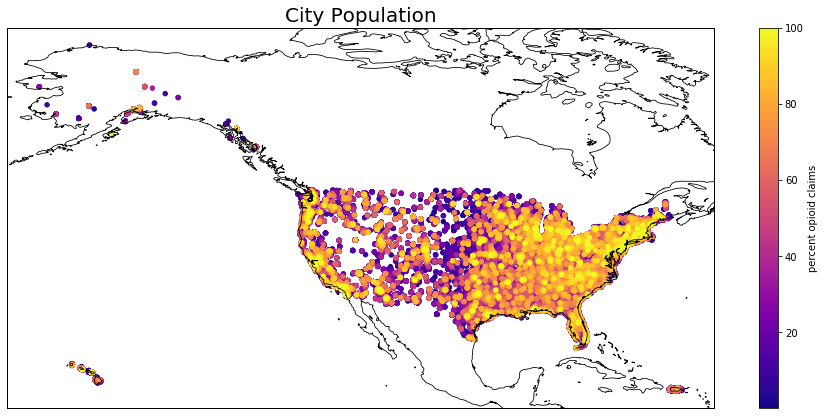

In [9]:

opioid_reduced.sort_values(by='percent opioid claims',ascending=True,inplace=True)
lat = opioid_reduced['lat']
lon = opioid_reduced['lng']
population = opioid_reduced['percent opioid claims']
from wrf import to_np, getvar, smooth2d, get_cartopy, cartopy_xlim, cartopy_ylim, latlon_coords


fig = plt.figure(figsize=(16,7))
# Set projection
ax = plt.axes(projection=ccrs.PlateCarree())

# Download and add the states and coastlines
ax.add_feature(cfeature.NaturalEarthFeature(
        category='cultural',
        name='admin_1_states_provinces_lines',
        scale='50m',
        facecolor='none'))
ax.coastlines('50m', linewidth=0.8)
ax.set_title('City Population',fontdict={'fontsize':20})

opioid_reduced.plot(kind='scatter',x='lng',y='lat',
                   c='percent opioid claims',ax=ax,
                   cmap=plt.get_cmap('plasma'),
                   colorbar=True)

population_df.sort_index(ascending=False,inplace=True)
fig.savefig('opioid_map.jpg',bbox_inches='tight')

plt.show()

# display opioid map by state

In [65]:
import plotly.plotly as py
import plotly.graph_objs as go 
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True) 
opioid_state=opioid_reduced.groupby(['state_id']).sum()[['total claims','opioid claims']]
opioid_state['percent opioid claims'] = opioid_state['opioid claims']/opioid_state['total claims']*100
opioid_state['standard deviation'] =opioid_reduced.groupby(['state_id']).std()['percent opioid claims']
data = dict(type = 'choropleth',
            locations = list(opioid_state.index),
            locationmode = 'USA-states',
            colorscale = scl,
            z = opioid_state['percent opioid claims'],
            colorbar = {'title':'Percent Opoid Claims'})

layout = dict(
    title = 'Percent Opioid Claims by State',
    geo = {'scope':'usa'}
)

choromap = go.Figure(data = [data],layout = layout)
fig = dict( data=data, layout=layout)
py.iplot( fig, validate=False, filename='temperature')

    

zip code                 474995
specialty description    474995
total claims             474995
opioid claims            474995
percent opioid claims    474995
doctor name              474995
specialty index          474995
city                     474995
state_id                 474995
lat                      474995
lng                      474995
population               474995
Mean Temp                474995
Min Temp                 474995
Max Temp                 474995
Median Income            474995
dtype: int64